In [90]:
import utils.fetcher_utils as fetcher
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import utils.preprocess_util as preproc


In [91]:
pd.set_option('display.max_columns', None)

In [92]:
# Get the data from the IMDb dataFrame
imdb_df = fetcher.aquireIMDbDataFrame()
imdb_df.head()

Reading data from ../resources\movie_metadata.csv


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,1.0,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,Doug Walker,Star Wars: Episode VII - The Force Awakens ...,8,143,NaN,0.0,NaN,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [93]:
drop_columns = ['movie_imdb_link','aspect_ratio', 'plot_keywords']

imdb_df_filtered = imdb_df.drop(columns=drop_columns)
imdb_df_filtered = imdb_df_filtered.dropna(subset='title_year')


In [94]:
imdb_X_train_filtered = imdb_df_filtered[sorted(imdb_df_filtered.columns)]

In [95]:
imdb_df_filtered = imdb_df_filtered[(imdb_df_filtered['gross']>1_000) & 
                                    (imdb_df_filtered['budget']>1_000) & 
                                    (imdb_df_filtered['country'] == 'USA') &
                                    (imdb_df['title_year']>1994)].drop(columns='country').reset_index(drop=True)
imdb_df_filtered

C:\Users\fagui\AppData\Local\Temp\ipykernel_23600\3164738777.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  imdb_df_filtered = imdb_df_filtered[(imdb_df_filtered['gross']>1_000) &


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,num_user_for_reviews,language,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,3054.0,English,PG-13,237000000.0,2009.0,936.0,7.9,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,1238.0,English,PG-13,300000000.0,2007.0,5000.0,7.1,0
2,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,2701.0,English,PG-13,250000000.0,2012.0,23000.0,8.5,164000
3,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,Daryl Sabara,John Carter,212204,1873,Polly Walker,1.0,738.0,English,PG-13,263700000.0,2012.0,632.0,6.6,24000
4,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,336530303.0,Action|Adventure|Romance,J.K. Simmons,Spider-Man 3,383056,46055,Kirsten Dunst,0.0,1902.0,English,PG-13,258000000.0,2007.0,11000.0,6.2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2657,Color,Jay Duplass,51.0,85.0,157.0,10.0,Katie Aselton,830.0,192467.0,Comedy|Drama|Romance,Mark Duplass,The Puffy Chair,4067,1064,Bari Hyman,0.0,71.0,English,R,15000.0,2005.0,224.0,6.6,297
2658,Color,Daryl Wein,22.0,88.0,38.0,211.0,Heather Burns,331.0,76382.0,Romance,Zoe Lister-Jones,Breaking Upwards,1194,1546,Ebon Moss-Bachrach,2.0,8.0,English,NaN,15000.0,2009.0,212.0,6.2,324
2659,Color,Shane Carruth,143.0,77.0,291.0,8.0,David Sullivan,291.0,424760.0,Drama|Sci-Fi|Thriller,Shane Carruth,Primer,72639,368,Casey Gooden,0.0,371.0,English,PG-13,7000.0,2004.0,45.0,7.0,19000
2660,Color,Edward Burns,14.0,95.0,0.0,133.0,Caitlin FitzGerald,296.0,4584.0,Comedy|Drama,Kerry Bishé,Newlyweds,1338,690,Daniella Pineda,1.0,14.0,English,Not Rated,9000.0,2011.0,205.0,6.4,413


In [96]:
imdb_df_filtered.dropna(inplace=True)

In [97]:
X = imdb_df_filtered.drop(columns=['imdb_score'])
y = imdb_df_filtered['imdb_score']

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [99]:
X_train

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,num_user_for_reviews,language,content_rating,budget,title_year,actor_2_facebook_likes,movie_facebook_likes
1449,Color,Robert Towne,28.0,117.0,162.0,745.0,Monica Potter,2000.0,777423.0,Biography|Drama|Sport,Billy Burke,Without Limits,5841,4351,Billy Crudup,0.0,57.0,English,PG-13,25000000.0,1998.0,878.0,942
1459,Color,Todd Phillips,123.0,88.0,480.0,497.0,Leah Remini,8000.0,74608545.0,Comedy,Will Ferrell,Old School,185258,10325,Patrick Fischler,4.0,404.0,English,R,24000000.0,2003.0,909.0,0
2487,Color,Steve Buscemi,43.0,95.0,12000.0,636.0,Debi Mazar,12000.0,695229.0,Comedy|Drama,Steve Buscemi,Trees Lounge,11369,14420,Carol Kane,1.0,65.0,English,R,1300000.0,1996.0,680.0,872
2117,Color,Marc Forby,26.0,97.0,3.0,204.0,Will Patton,679.0,883887.0,Drama,Q'orianka Kilcher,Princess Kaiulani,1201,1426,Shaun Evans,3.0,14.0,English,PG,9000000.0,2009.0,537.0,0
2562,Black and White,Daniel Myrick,360.0,81.0,19.0,39.0,Joshua Leonard,170.0,140530114.0,Horror,Heather Donahue,The Blair Witch Project,186786,399,Michael C. Williams,0.0,3400.0,English,R,60000.0,1999.0,170.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1641,Color,J.C. Chandor,350.0,125.0,78.0,745.0,Ashley Williams,1000.0,5749134.0,Action|Crime|Drama|Thriller,David Oyelowo,A Most Violent Year,45799,3979,Albert Brooks,0.0,180.0,English,R,20000000.0,2014.0,969.0,0
1097,Color,Ken Kwapis,120.0,91.0,42.0,766.0,Christine Taylor,49000.0,43792641.0,Comedy|Romance,Robin Williams,License to Wed,32157,52566,Mindy Kaling,3.0,119.0,English,PG-13,35000000.0,2007.0,838.0,913
1132,Color,Dominic Sena,166.0,101.0,57.0,230.0,Bashar Rahal,1000.0,10268846.0,Action|Crime|Mystery|Thriller,Tom Skerritt,Whiteout,31918,1947,Shawn Doyle,1.0,142.0,English,R,35000000.0,2009.0,603.0,0
1296,Color,Ben Falcone,154.0,99.0,265.0,265.0,Tyler Labine,22000.0,63034755.0,Comedy,Peter Dinklage,The Boss,16984,23562,Ben Falcone,1.0,96.0,English,R,29000000.0,2016.0,779.0,0


In [100]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1972 entries, 1449 to 862
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      1972 non-null   object 
 1   director_name              1972 non-null   object 
 2   num_critic_for_reviews     1972 non-null   float64
 3   duration                   1972 non-null   float64
 4   director_facebook_likes    1972 non-null   float64
 5   actor_3_facebook_likes     1972 non-null   float64
 6   actor_2_name               1972 non-null   object 
 7   actor_1_facebook_likes     1972 non-null   float64
 8   gross                      1972 non-null   float64
 9   genres                     1972 non-null   object 
 10  actor_1_name               1972 non-null   object 
 11  movie_title                1972 non-null   object 
 12  num_voted_users            1972 non-null   int64  
 13  cast_total_facebook_likes  1972 non-null   int64  


In [101]:
X_train = preproc._director_frequence(X_train)
X_train


,color,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,num_user_for_reviews,language,content_rating,budget,title_year,actor_2_facebook_likes,movie_facebook_likes,director_frequency
1449,Color,28.0,117.0,162.0,745.0,Monica Potter,2000.0,777423.0,Biography|Drama|Sport,Billy Burke,Without Limits,5841,4351,Billy Crudup,0.0,57.0,English,PG-13,25000000.0,1998.0,878.0,942,1
1459,Color,123.0,88.0,480.0,497.0,Leah Remini,8000.0,74608545.0,Comedy,Will Ferrell,Old School,185258,10325,Patrick Fischler,4.0,404.0,English,R,24000000.0,2003.0,909.0,0,6
2487,Color,43.0,95.0,12000.0,636.0,Debi Mazar,12000.0,695229.0,Comedy|Drama,Steve Buscemi,Trees Lounge,11369,14420,Carol Kane,1.0,65.0,English,R,1300000.0,1996.0,680.0,872,2
2117,Color,26.0,97.0,3.0,204.0,Will Patton,679.0,883887.0,Drama,Q'orianka Kilcher,Princess Kaiulani,1201,1426,Shaun Evans,3.0,14.0,English,PG,9000000.0,2009.0,537.0,0,1
2562,Black and White,360.0,81.0,19.0,39.0,Joshua Leonard,170.0,140530114.0,Horror,Heather Donahue,The Blair Witch Project,186786,399,Michael C. Williams,0.0,3400.0,English,R,60000.0,1999.0,170.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1641,Color,350.0,125.0,78.0,745.0,Ashley Williams,1000.0,5749134.0,Action|Crime|Drama|Thriller,David Oyelowo,A Most Violent Year,45799,3979,Albert Brooks,0.0,180.0,English,R,20000000.0,2014.0,969.0,0,1
1097,Color,120.0,91.0,42.0,766.0,Christine Taylor,49000.0,43792641.0,Comedy|Romance,Robin Williams,License to Wed,32157,52566,Mindy Kaling,3.0,119.0,English,PG-13,35000000.0,2007.0,838.0,913,3
1132,Color,166.0,101.0,57.0,230.0,Bashar Rahal,1000.0,10268846.0,Action|Crime|Mystery|Thriller,Tom Skerritt,Whiteout,31918,1947,Shawn Doyle,1.0,142.0,English,R,35000000.0,2009.0,603.0,0,2
1296,Color,154.0,99.0,265.0,265.0,Tyler Labine,22000.0,63034755.0,Comedy,Peter Dinklage,The Boss,16984,23562,Ben Falcone,1.0,96.0,English,R,29000000.0,2016.0,779.0,0,2


In [102]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1972 entries, 1449 to 862
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      1972 non-null   object 
 1   num_critic_for_reviews     1972 non-null   float64
 2   duration                   1972 non-null   float64
 3   director_facebook_likes    1972 non-null   float64
 4   actor_3_facebook_likes     1972 non-null   float64
 5   actor_2_name               1972 non-null   object 
 6   actor_1_facebook_likes     1972 non-null   float64
 7   gross                      1972 non-null   float64
 8   genres                     1972 non-null   object 
 9   actor_1_name               1972 non-null   object 
 10  movie_title                1972 non-null   object 
 11  num_voted_users            1972 non-null   int64  
 12  cast_total_facebook_likes  1972 non-null   int64  
 13  actor_3_name               1972 non-null   object 


In [103]:
X_train = preproc._process_genres(X_train)
X_train

,color,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,num_user_for_reviews,language,content_rating,budget,title_year,actor_2_facebook_likes,movie_facebook_likes,director_frequency,Drama,Comedy,Thriller,Action,Romance,Adventure,Crime,Sci-Fi,Fantasy,Family,other_genre
1449,Color,28.0,117.0,162.0,745.0,Monica Potter,2000.0,777423.0,Billy Burke,Without Limits,5841,4351,Billy Crudup,0.0,57.0,English,PG-13,25000000.0,1998.0,878.0,942,1,1,0,0,0,0,0,0,0,0,0,1
1459,Color,123.0,88.0,480.0,497.0,Leah Remini,8000.0,74608545.0,Will Ferrell,Old School,185258,10325,Patrick Fischler,4.0,404.0,English,R,24000000.0,2003.0,909.0,0,6,0,1,0,0,0,0,0,0,0,0,0
2487,Color,43.0,95.0,12000.0,636.0,Debi Mazar,12000.0,695229.0,Steve Buscemi,Trees Lounge,11369,14420,Carol Kane,1.0,65.0,English,R,1300000.0,1996.0,680.0,872,2,1,1,0,0,0,0,0,0,0,0,0
2117,Color,26.0,97.0,3.0,204.0,Will Patton,679.0,883887.0,Q'orianka Kilcher,Princess Kaiulani,1201,1426,Shaun Evans,3.0,14.0,English,PG,9000000.0,2009.0,537.0,0,1,1,0,0,0,0,0,0,0,0,0,0
2562,Black and White,360.0,81.0,19.0,39.0,Joshua Leonard,170.0,140530114.0,Heather Donahue,The Blair Witch Project,186786,399,Michael C. Williams,0.0,3400.0,English,R,60000.0,1999.0,170.0,0,1,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1641,Color,350.0,125.0,78.0,745.0,Ashley Williams,1000.0,5749134.0,David Oyelowo,A Most Violent Year,45799,3979,Albert Brooks,0.0,180.0,English,R,20000000.0,2014.0,969.0,0,1,1,0,1,1,0,0,1,0,0,0,0
1097,Color,120.0,91.0,42.0,766.0,Christine Taylor,49000.0,43792641.0,Robin Williams,License to Wed,32157,52566,Mindy Kaling,3.0,119.0,English,PG-13,35000000.0,2007.0,838.0,913,3,0,1,0,0,1,0,0,0,0,0,0
1132,Color,166.0,101.0,57.0,230.0,Bashar Rahal,1000.0,10268846.0,Tom Skerritt,Whiteout,31918,1947,Shawn Doyle,1.0,142.0,English,R,35000000.0,2009.0,603.0,0,2,0,0,1,1,0,0,1,0,0,0,1
1296,Color,154.0,99.0,265.0,265.0,Tyler Labine,22000.0,63034755.0,Peter Dinklage,The Boss,16984,23562,Ben Falcone,1.0,96.0,English,R,29000000.0,2016.0,779.0,0,2,0,1,0,0,0,0,0,0,0,0,0


In [104]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1972 entries, 1449 to 862
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      1972 non-null   object 
 1   num_critic_for_reviews     1972 non-null   float64
 2   duration                   1972 non-null   float64
 3   director_facebook_likes    1972 non-null   float64
 4   actor_3_facebook_likes     1972 non-null   float64
 5   actor_2_name               1972 non-null   object 
 6   actor_1_facebook_likes     1972 non-null   float64
 7   gross                      1972 non-null   float64
 8   actor_1_name               1972 non-null   object 
 9   movie_title                1972 non-null   object 
 10  num_voted_users            1972 non-null   int64  
 11  cast_total_facebook_likes  1972 non-null   int64  
 12  actor_3_name               1972 non-null   object 
 13  facenumber_in_poster       1972 non-null   float64


In [105]:
content_rating_replaced_df = preproc._bucket_contentRatings(X_train)
content_rating_replaced_df

,color,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,num_user_for_reviews,language,content_rating,budget,title_year,actor_2_facebook_likes,movie_facebook_likes,director_frequency,Drama,Comedy,Thriller,Action,Romance,Adventure,Crime,Sci-Fi,Fantasy,Family,other_genre,rating_bin
1449,Color,28.0,117.0,162.0,745.0,Monica Potter,2000.0,777423.0,Billy Burke,Without Limits,5841,4351,Billy Crudup,0.0,57.0,English,PG-13,25000000.0,1998.0,878.0,942,1,1,0,0,0,0,0,0,0,0,0,1,PG-13
1459,Color,123.0,88.0,480.0,497.0,Leah Remini,8000.0,74608545.0,Will Ferrell,Old School,185258,10325,Patrick Fischler,4.0,404.0,English,R,24000000.0,2003.0,909.0,0,6,0,1,0,0,0,0,0,0,0,0,0,R
2487,Color,43.0,95.0,12000.0,636.0,Debi Mazar,12000.0,695229.0,Steve Buscemi,Trees Lounge,11369,14420,Carol Kane,1.0,65.0,English,R,1300000.0,1996.0,680.0,872,2,1,1,0,0,0,0,0,0,0,0,0,R
2117,Color,26.0,97.0,3.0,204.0,Will Patton,679.0,883887.0,Q'orianka Kilcher,Princess Kaiulani,1201,1426,Shaun Evans,3.0,14.0,English,PG,9000000.0,2009.0,537.0,0,1,1,0,0,0,0,0,0,0,0,0,0,PG
2562,Black and White,360.0,81.0,19.0,39.0,Joshua Leonard,170.0,140530114.0,Heather Donahue,The Blair Witch Project,186786,399,Michael C. Williams,0.0,3400.0,English,R,60000.0,1999.0,170.0,0,1,0,0,0,0,0,0,0,0,0,0,1,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1641,Color,350.0,125.0,78.0,745.0,Ashley Williams,1000.0,5749134.0,David Oyelowo,A Most Violent Year,45799,3979,Albert Brooks,0.0,180.0,English,R,20000000.0,2014.0,969.0,0,1,1,0,1,1,0,0,1,0,0,0,0,R
1097,Color,120.0,91.0,42.0,766.0,Christine Taylor,49000.0,43792641.0,Robin Williams,License to Wed,32157,52566,Mindy Kaling,3.0,119.0,English,PG-13,35000000.0,2007.0,838.0,913,3,0,1,0,0,1,0,0,0,0,0,0,PG-13
1132,Color,166.0,101.0,57.0,230.0,Bashar Rahal,1000.0,10268846.0,Tom Skerritt,Whiteout,31918,1947,Shawn Doyle,1.0,142.0,English,R,35000000.0,2009.0,603.0,0,2,0,0,1,1,0,0,1,0,0,0,1,R
1296,Color,154.0,99.0,265.0,265.0,Tyler Labine,22000.0,63034755.0,Peter Dinklage,The Boss,16984,23562,Ben Falcone,1.0,96.0,English,R,29000000.0,2016.0,779.0,0,2,0,1,0,0,0,0,0,0,0,0,0,R


In [106]:
content_rating_replaced_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1972 entries, 1449 to 862
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      1972 non-null   object 
 1   num_critic_for_reviews     1972 non-null   float64
 2   duration                   1972 non-null   float64
 3   director_facebook_likes    1972 non-null   float64
 4   actor_3_facebook_likes     1972 non-null   float64
 5   actor_2_name               1972 non-null   object 
 6   actor_1_facebook_likes     1972 non-null   float64
 7   gross                      1972 non-null   float64
 8   actor_1_name               1972 non-null   object 
 9   movie_title                1972 non-null   object 
 10  num_voted_users            1972 non-null   int64  
 11  cast_total_facebook_likes  1972 non-null   int64  
 12  actor_3_name               1972 non-null   object 
 13  facenumber_in_poster       1972 non-null   float64


In [107]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1972 entries, 1449 to 862
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      1972 non-null   object 
 1   num_critic_for_reviews     1972 non-null   float64
 2   duration                   1972 non-null   float64
 3   director_facebook_likes    1972 non-null   float64
 4   actor_3_facebook_likes     1972 non-null   float64
 5   actor_2_name               1972 non-null   object 
 6   actor_1_facebook_likes     1972 non-null   float64
 7   gross                      1972 non-null   float64
 8   actor_1_name               1972 non-null   object 
 9   movie_title                1972 non-null   object 
 10  num_voted_users            1972 non-null   int64  
 11  cast_total_facebook_likes  1972 non-null   int64  
 12  actor_3_name               1972 non-null   object 
 13  facenumber_in_poster       1972 non-null   float64


In [108]:
encoder = OneHotEncoder(sparse_output=False)  
content_rating_encoded = encoder.fit_transform(content_rating_replaced_df[["rating_bin"]])
content_rating_encoded = pd.DataFrame(content_rating_encoded, columns=encoder.get_feature_names_out(["rating_bin"]))
content_rating_encoded

,rating_bin_PG,rating_bin_PG-13,rating_bin_R,rating_bin_other
0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0
...,...,...,...,...
1967,0.0,0.0,1.0,0.0
1968,0.0,1.0,0.0,0.0
1969,0.0,0.0,1.0,0.0
1970,0.0,0.0,1.0,0.0


In [109]:
content_rating_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1972 entries, 0 to 1971
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rating_bin_PG     1972 non-null   float64
 1   rating_bin_PG-13  1972 non-null   float64
 2   rating_bin_R      1972 non-null   float64
 3   rating_bin_other  1972 non-null   float64
dtypes: float64(4)
memory usage: 61.8 KB


In [110]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1972 entries, 1449 to 862
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      1972 non-null   object 
 1   num_critic_for_reviews     1972 non-null   float64
 2   duration                   1972 non-null   float64
 3   director_facebook_likes    1972 non-null   float64
 4   actor_3_facebook_likes     1972 non-null   float64
 5   actor_2_name               1972 non-null   object 
 6   actor_1_facebook_likes     1972 non-null   float64
 7   gross                      1972 non-null   float64
 8   actor_1_name               1972 non-null   object 
 9   movie_title                1972 non-null   object 
 10  num_voted_users            1972 non-null   int64  
 11  cast_total_facebook_likes  1972 non-null   int64  
 12  actor_3_name               1972 non-null   object 
 13  facenumber_in_poster       1972 non-null   float64


In [111]:
X_train = pd.concat([X_train.reset_index(drop=True), content_rating_encoded], axis=1)
# X_train.drop('content_rating', axis=1, inplace=True)
X_train

,color,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,num_user_for_reviews,language,content_rating,budget,title_year,actor_2_facebook_likes,movie_facebook_likes,director_frequency,Drama,Comedy,Thriller,Action,Romance,Adventure,Crime,Sci-Fi,Fantasy,Family,other_genre,rating_bin_PG,rating_bin_PG-13,rating_bin_R,rating_bin_other
0,Color,28.0,117.0,162.0,745.0,Monica Potter,2000.0,777423.0,Billy Burke,Without Limits,5841,4351,Billy Crudup,0.0,57.0,English,PG-13,25000000.0,1998.0,878.0,942,1,1,0,0,0,0,0,0,0,0,0,1,0.0,1.0,0.0,0.0
1,Color,123.0,88.0,480.0,497.0,Leah Remini,8000.0,74608545.0,Will Ferrell,Old School,185258,10325,Patrick Fischler,4.0,404.0,English,R,24000000.0,2003.0,909.0,0,6,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0
2,Color,43.0,95.0,12000.0,636.0,Debi Mazar,12000.0,695229.0,Steve Buscemi,Trees Lounge,11369,14420,Carol Kane,1.0,65.0,English,R,1300000.0,1996.0,680.0,872,2,1,1,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0
3,Color,26.0,97.0,3.0,204.0,Will Patton,679.0,883887.0,Q'orianka Kilcher,Princess Kaiulani,1201,1426,Shaun Evans,3.0,14.0,English,PG,9000000.0,2009.0,537.0,0,1,1,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0
4,Black and White,360.0,81.0,19.0,39.0,Joshua Leonard,170.0,140530114.0,Heather Donahue,The Blair Witch Project,186786,399,Michael C. Williams,0.0,3400.0,English,R,60000.0,1999.0,170.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1967,Color,350.0,125.0,78.0,745.0,Ashley Williams,1000.0,5749134.0,David Oyelowo,A Most Violent Year,45799,3979,Albert Brooks,0.0,180.0,English,R,20000000.0,2014.0,969.0,0,1,1,0,1,1,0,0,1,0,0,0,0,0.0,0.0,1.0,0.0
1968,Color,120.0,91.0,42.0,766.0,Christine Taylor,49000.0,43792641.0,Robin Williams,License to Wed,32157,52566,Mindy Kaling,3.0,119.0,English,PG-13,35000000.0,2007.0,838.0,913,3,0,1,0,0,1,0,0,0,0,0,0,0.0,1.0,0.0,0.0
1969,Color,166.0,101.0,57.0,230.0,Bashar Rahal,1000.0,10268846.0,Tom Skerritt,Whiteout,31918,1947,Shawn Doyle,1.0,142.0,English,R,35000000.0,2009.0,603.0,0,2,0,0,1,1,0,0,1,0,0,0,1,0.0,0.0,1.0,0.0
1970,Color,154.0,99.0,265.0,265.0,Tyler Labine,22000.0,63034755.0,Peter Dinklage,The Boss,16984,23562,Ben Falcone,1.0,96.0,English,R,29000000.0,2016.0,779.0,0,2,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0


In [112]:
X_train = preproc._actor_frequency(X_train)
X_train

,color,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,movie_title,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,language,content_rating,budget,title_year,actor_2_facebook_likes,movie_facebook_likes,director_frequency,Drama,Comedy,Thriller,Action,Romance,Adventure,Crime,Sci-Fi,Fantasy,Family,other_genre,rating_bin_PG,rating_bin_PG-13,rating_bin_R,rating_bin_other,actor_1_frequency,actor_2_frequency,actor_3_frequency,total_actor_frequency
0,Color,28.0,117.0,162.0,745.0,2000.0,777423.0,Without Limits,5841,4351,0.0,57.0,English,PG-13,25000000.0,1998.0,878.0,942,1,1,0,0,0,0,0,0,0,0,0,1,0.0,1.0,0.0,0.0,5,6,7,18
1,Color,123.0,88.0,480.0,497.0,8000.0,74608545.0,Old School,185258,10325,4.0,404.0,English,R,24000000.0,2003.0,909.0,0,6,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,20,1,2,23
2,Color,43.0,95.0,12000.0,636.0,12000.0,695229.0,Trees Lounge,11369,14420,1.0,65.0,English,R,1300000.0,1996.0,680.0,872,2,1,1,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,21,4,1,26
3,Color,26.0,97.0,3.0,204.0,679.0,883887.0,Princess Kaiulani,1201,1426,3.0,14.0,English,PG,9000000.0,2009.0,537.0,0,1,1,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,1,6,1,8
4,Black and White,360.0,81.0,19.0,39.0,170.0,140530114.0,The Blair Witch Project,186786,399,0.0,3400.0,English,R,60000.0,1999.0,170.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,1.0,0.0,1,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1967,Color,350.0,125.0,78.0,745.0,1000.0,5749134.0,A Most Violent Year,45799,3979,0.0,180.0,English,R,20000000.0,2014.0,969.0,0,1,1,0,1,1,0,0,1,0,0,0,0,0.0,0.0,1.0,0.0,6,2,2,10
1968,Color,120.0,91.0,42.0,766.0,49000.0,43792641.0,License to Wed,32157,52566,3.0,119.0,English,PG-13,35000000.0,2007.0,838.0,913,3,0,1,0,0,1,0,0,0,0,0,0,0.0,1.0,0.0,0.0,12,2,2,16
1969,Color,166.0,101.0,57.0,230.0,1000.0,10268846.0,Whiteout,31918,1947,1.0,142.0,English,R,35000000.0,2009.0,603.0,0,2,0,0,1,1,0,0,1,0,0,0,1,0.0,0.0,1.0,0.0,5,2,1,8
1970,Color,154.0,99.0,265.0,265.0,22000.0,63034755.0,The Boss,16984,23562,1.0,96.0,English,R,29000000.0,2016.0,779.0,0,2,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,8,5,2,15


In [113]:
X_train['total_facebook_likes'] = X_train['actor_1_facebook_likes'] + X_train['actor_2_facebook_likes'] + X_train['actor_3_facebook_likes']
X_train #.sort_values(by='movie_title') Biography|Drama|Sport

,color,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,movie_title,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,language,content_rating,budget,title_year,actor_2_facebook_likes,movie_facebook_likes,director_frequency,Drama,Comedy,Thriller,Action,Romance,Adventure,Crime,Sci-Fi,Fantasy,Family,other_genre,rating_bin_PG,rating_bin_PG-13,rating_bin_R,rating_bin_other,actor_1_frequency,actor_2_frequency,actor_3_frequency,total_actor_frequency,total_facebook_likes
0,Color,28.0,117.0,162.0,745.0,2000.0,777423.0,Without Limits,5841,4351,0.0,57.0,English,PG-13,25000000.0,1998.0,878.0,942,1,1,0,0,0,0,0,0,0,0,0,1,0.0,1.0,0.0,0.0,5,6,7,18,3623.0
1,Color,123.0,88.0,480.0,497.0,8000.0,74608545.0,Old School,185258,10325,4.0,404.0,English,R,24000000.0,2003.0,909.0,0,6,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,20,1,2,23,9406.0
2,Color,43.0,95.0,12000.0,636.0,12000.0,695229.0,Trees Lounge,11369,14420,1.0,65.0,English,R,1300000.0,1996.0,680.0,872,2,1,1,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,21,4,1,26,13316.0
3,Color,26.0,97.0,3.0,204.0,679.0,883887.0,Princess Kaiulani,1201,1426,3.0,14.0,English,PG,9000000.0,2009.0,537.0,0,1,1,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,1,6,1,8,1420.0
4,Black and White,360.0,81.0,19.0,39.0,170.0,140530114.0,The Blair Witch Project,186786,399,0.0,3400.0,English,R,60000.0,1999.0,170.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,1.0,0.0,1,1,1,3,379.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1967,Color,350.0,125.0,78.0,745.0,1000.0,5749134.0,A Most Violent Year,45799,3979,0.0,180.0,English,R,20000000.0,2014.0,969.0,0,1,1,0,1,1,0,0,1,0,0,0,0,0.0,0.0,1.0,0.0,6,2,2,10,2714.0
1968,Color,120.0,91.0,42.0,766.0,49000.0,43792641.0,License to Wed,32157,52566,3.0,119.0,English,PG-13,35000000.0,2007.0,838.0,913,3,0,1,0,0,1,0,0,0,0,0,0,0.0,1.0,0.0,0.0,12,2,2,16,50604.0
1969,Color,166.0,101.0,57.0,230.0,1000.0,10268846.0,Whiteout,31918,1947,1.0,142.0,English,R,35000000.0,2009.0,603.0,0,2,0,0,1,1,0,0,1,0,0,0,1,0.0,0.0,1.0,0.0,5,2,1,8,1833.0
1970,Color,154.0,99.0,265.0,265.0,22000.0,63034755.0,The Boss,16984,23562,1.0,96.0,English,R,29000000.0,2016.0,779.0,0,2,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,8,5,2,15,23044.0


In [119]:
drop_columns = ['actor_1_facebook_likes', 'actor_2_facebook_likes','actor_3_facebook_likes','color','language','movie_title','actor_1_frequency', 'actor_2_frequency', 
                'actor_3_frequency', 'content_rating'
                ]

X_train = X_train.drop(columns=drop_columns)
X_train

,num_critic_for_reviews,duration,director_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,movie_facebook_likes,director_frequency,Drama,Comedy,Thriller,Action,Romance,Adventure,Crime,Sci-Fi,Fantasy,Family,other_genre,rating_bin_PG,rating_bin_PG-13,rating_bin_R,rating_bin_other,total_actor_frequency,total_facebook_likes
0,28.0,117.0,162.0,777423.0,5841,4351,0.0,57.0,25000000.0,1998.0,942,1,1,0,0,0,0,0,0,0,0,0,1,0.0,1.0,0.0,0.0,18,3623.0
1,123.0,88.0,480.0,74608545.0,185258,10325,4.0,404.0,24000000.0,2003.0,0,6,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,23,9406.0
2,43.0,95.0,12000.0,695229.0,11369,14420,1.0,65.0,1300000.0,1996.0,872,2,1,1,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,26,13316.0
3,26.0,97.0,3.0,883887.0,1201,1426,3.0,14.0,9000000.0,2009.0,0,1,1,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,8,1420.0
4,360.0,81.0,19.0,140530114.0,186786,399,0.0,3400.0,60000.0,1999.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,1.0,0.0,3,379.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1967,350.0,125.0,78.0,5749134.0,45799,3979,0.0,180.0,20000000.0,2014.0,0,1,1,0,1,1,0,0,1,0,0,0,0,0.0,0.0,1.0,0.0,10,2714.0
1968,120.0,91.0,42.0,43792641.0,32157,52566,3.0,119.0,35000000.0,2007.0,913,3,0,1,0,0,1,0,0,0,0,0,0,0.0,1.0,0.0,0.0,16,50604.0
1969,166.0,101.0,57.0,10268846.0,31918,1947,1.0,142.0,35000000.0,2009.0,0,2,0,0,1,1,0,0,1,0,0,0,1,0.0,0.0,1.0,0.0,8,1833.0
1970,154.0,99.0,265.0,63034755.0,16984,23562,1.0,96.0,29000000.0,2016.0,0,2,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,15,23044.0


In [123]:
len(['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'Horror', 'Romance', 'Sci-Fi', 'Thriller', 'actor_total_facebook_likes', 'budget', 'cast_total_facebook_likes', 'content_rating', 'director_facebook_likes', 'director_frequency', 'duration', 'facenumber_in_poster', 'gross', 'imdb_score', 'movie_facebook_likes', 'num_critic_for_reviews', 'num_user_for_reviews', 'num_voted_users', 'other_genre', 'rating_bin', 'title_year', 'total_actor_frequency'])

29

In [115]:
scale_model = StandardScaler()





# Label Encoder

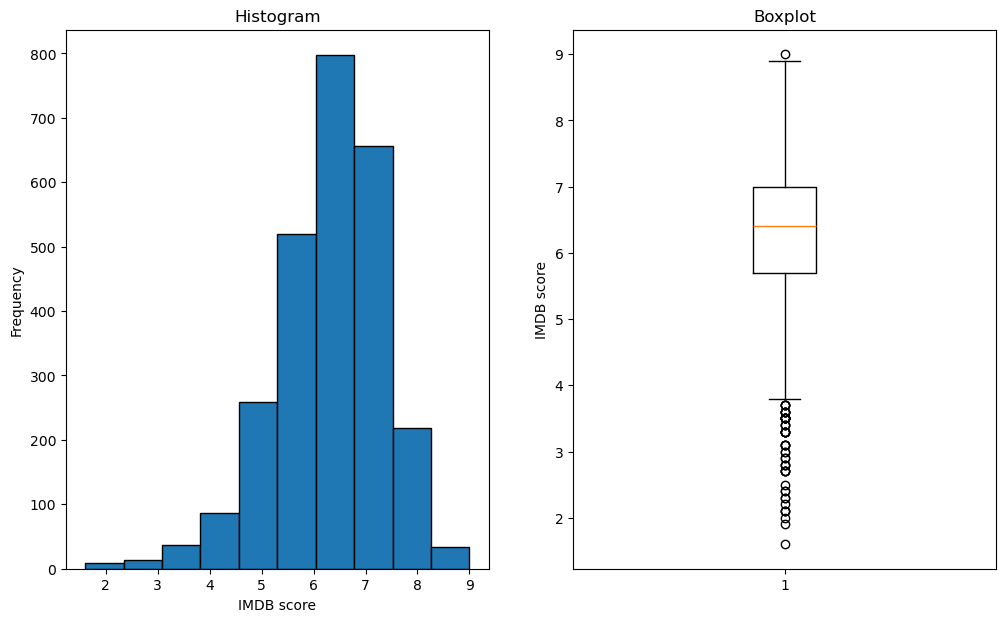

In [116]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))

# Plot the histogram on the first subplot
ax1.hist(imdb_df_filtered['imdb_score'], bins=10, edgecolor='black')
ax1.set_title('Histogram')
ax1.set_xlabel('IMDB score')
ax1.set_ylabel('Frequency')

# Plot the boxplot on the second subplot
ax2.boxplot(imdb_df_filtered['imdb_score'])
ax2.set_title('Boxplot')
ax2.set_ylabel('IMDB score')

# Show the figure
plt.show()

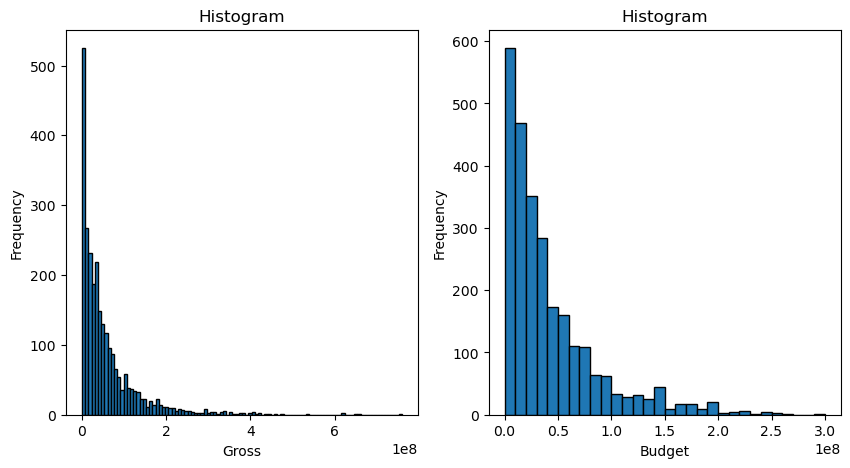

In [117]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the histogram on the first subplot
ax1.hist(imdb_df_filtered['gross'], bins=100, edgecolor='black')
ax1.set_title('Histogram')
ax1.set_xlabel('Gross')
ax1.set_ylabel('Frequency')

# Plot the histogram on the first subplot
ax2.hist(imdb_df_filtered['budget'], bins=30, edgecolor='black')
ax2.set_title('Histogram')
ax2.set_xlabel('Budget')
ax2.set_ylabel('Frequency')

# Show the figure
plt.show()

In [118]:
# Sample data
data = {
    'Category': ['A', 'B', 'A', 'C', 'B', 'C', 'A', 'D', 'E', 'C'],
    'Target': [1, 0, 1, 0, 1, 0, 1, 1, 0, 0]
}
df = pd.DataFrame(data)

# Calculate the mean of the target for each category
target_mean = df.groupby('Category')['Target'].mean()

# Map the mean back to the original dataframe
df['Category_Encoded'] = df['Category'].map(target_mean)